# DVR Sales Data Merge for IR

## Without Householding - Accounts Only 

Creates a HH revenue dataframe with engagement stats directly applied at the account level
- dir: nutrien-digital/ir-metrics
- files:
  - sales: cust_org_product_20191024.csv
---
#### TODO:
- 

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

# set global for os
if os.name == 'posix':
    mac = True
else:
    mac = False
    
# source data are flatfiles
if mac == False:
    df_path = r"C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\ir_metrics"
else:
    df_path = r"/Users/ma9558996/Documents/DVR-Metrics-Data"      

# read pickle file and output
# there is no conversion of the output
def un_pickle(pkl_fname):
    with open(pkl_fname, 'rb') as handle:
        result = pickle.load(handle)
    return result

# read the pickles to return engagement df
# output df of the dataset and print key stats
def read_engagement_df(p_file, p_file_path):
    df = pd.DataFrame(un_pickle(os.path.join(p_file_path, p_file)))
    # get the account id out of the list
    # assumes 1 record per "accounts"
    df.loc[:, 'acct_id'] = df['accounts'].map(lambda x: x[0])
    df = df.drop('accounts', axis=1).copy()

    print('reading file: {}'.format(p_file))
    
    return df

# print basic count stats for engagement df
def print_df_stats(df):
    print('count records:                       {:,}'.format(len(df)))
    if 'acct_id' in df.columns:
        print('count distinct digital account IDs   {:,}'.format(len(df['acct_id'].unique())))
    if 'hh_id' in df.columns:
        print('count distinct digital household IDs {:,}'.format(len(df['hh_id'].unique())))
    if 'person_eid' in df.columns:
        print('count distinct digital person_EIDs   {:,}'.format(len(df['person_eid'].unique())))
    if 'hh_engaged' in df.columns:
        print('count digitally engaged hh IDs       {:,}'.format(len(df.query('hh_engaged == True'))))
        print('count digitally NON-engaged hh IDs   {:,}'.format(len(df.query('hh_engaged == False'))))
    if 'is_digital' in df.columns:
        print('count digital records                {:,}'.format(len(df.query('is_digital == True'))))
        print('count NON-digital records            {:,}'.format(len(df.query('is_digital == False'))))
        

### customer visits and engagement by account 

In [2]:
# note that hh_ids can be duplicated where there are more than 1 user linked to the same account
# we want to attribute account engagement to the SUM of the return visits for the same account
# so we want to summarize engagement by acct_id and aggregate by the SUM of return visits for each acct_id/hh_id
# returns the sum of user return visits by account
def comp_eng_sum_by_acct(df):
   # pivot on hh_id and sum on return visits to compute engaged v. non-engaged
    df_pvt = df.pivot_table(index=['hh_id','acct_id'], \
                                 values=['person_return_visits'], aggfunc='sum') 
    return pd.DataFrame(df_pvt.to_records())

In [9]:
eng_stats_filename = '20191023-bq-results-portal usage.csv'
eng_stats_df = pd.read_csv(os.path.join(df_path, eng_stats_filename))
eng_stats_df.head()
print_df_stats(eng_stats_df)
# eng_stats_sum_df = comp_eng_sum_by_acct(eng_stats_df)
# print_df_stats(eng_stats_sum_df)
# eng_stats_sum_df.head()

count records:                       33,164


In [10]:
# compute the engaged v un-engaged hh/accts 
# default return visit threshold for engagement == 2 visits
def compute_eng_vs_noneng_stats(df, return_visit_thresh=2):
    df['hh_engaged'] = eng_stats_sum_df['person_return_visits'] >= return_visit_thresh
    # since this has to be a digital df...
    df['is_digital'] = True 

In [11]:
compute_eng_vs_noneng_stats(eng_stats_sum_df)
print_df_stats(eng_stats_sum_df)
eng_stats_sum_df.head()

count records:                       35,022
count distinct digital account IDs   35,022
count distinct digital household IDs 35,022
count digitally engaged hh IDs       19,620
count digitally NON-engaged hh IDs   15,402
count digital records                35,022
count NON-digital records            0


,hh_id,acct_id,person_return_visits,hh_engaged,is_digital
0,AH_1001004,1001004,1,False,True
1,AH_1001008,1001008,2,True,True
2,AH_1001014,1001014,26,True,True
3,AH_1001057,1001057,13,True,True
4,AH_1001132,1001132,4,True,True


In [12]:
# get the non digital accounts
# single_account_non_digital_households
nondig_hh_df = read_engagement_df('single_account_non_digital_households.pickle', f_path)
# align columns with engaged df
nondig_hh_df['person_return_visits'] = int(-1) # no data
nondig_hh_df['hh_engaged'] = False
nondig_hh_df['is_digital'] = False

print_df_stats(nondig_hh_df)
nondig_hh_df.head()

reading file: single_account_non_digital_households.pickle
count records:                       431,550
count distinct digital account IDs   431,550
count distinct digital household IDs 431,550
count digitally engaged hh IDs       0
count digitally NON-engaged hh IDs   431,550
count digital records                0
count NON-digital records            431,550


,hh_id,acct_id,person_return_visits,hh_engaged,is_digital
0,AH_1528043,1528043,-1,False,False
1,AH_1509335,1509335,-1,False,False
2,AH_1705430,1705430,-1,False,False
3,AH_1509958,1509958,-1,False,False
4,AH_1576722,1576722,-1,False,False


In [14]:
# concatenate the HH engagement data 
acct_engagement_df = pd.concat([eng_stats_sum_df, nondig_hh_df])
print_df_stats(acct_engagement_df)
# size of household engagement data should match 
assert(len(acct_engagement_df) == (len(nondig_hh_df['hh_id'].unique()) + \
                                        len(eng_stats_sum_df['hh_id'].unique())))

count records:                       466,572
count distinct digital account IDs   466,572
count distinct digital household IDs 466,572
count digitally engaged hh IDs       19,620
count digitally NON-engaged hh IDs   446,952
count digital records                35,022
count NON-digital records            431,550


In [15]:
acct_engagement_df.head()

,hh_id,acct_id,person_return_visits,hh_engaged,is_digital
0,AH_1001004,1001004,1,False,True
1,AH_1001008,1001008,2,True,True
2,AH_1001014,1001014,26,True,True
3,AH_1001057,1001057,13,True,True
4,AH_1001132,1001132,4,True,True


In [16]:
acct_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466572 entries, 0 to 431549
Data columns (total 5 columns):
hh_id                   466572 non-null object
acct_id                 466572 non-null object
person_return_visits    466572 non-null int64
hh_engaged              466572 non-null bool
is_digital              466572 non-null bool
dtypes: bool(2), int64(1), object(2)
memory usage: 15.1+ MB


In [17]:
acct_engagement_df = un_pickle(os.path.join(df_path, "201910-cust-engagement.pickle"))
acct_engagement_df = acct_engagement_df.rename(columns={'ADMIN_CONTRACT_ID':'acct_id', 'ORG_NAME':'org_name', \
                                                'CREATED_DT':'created_dt','userId':'user_id'})
acct_engagement_df.head()

,org_name,acct_id,created_dt,user_id,num_visits,earliest_visit_date,latest_visit_date,is_digital,hh_engaged,hh_id
0,Baldwin Ag,1226470,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,True,True,AH_1226470
1,Baldwin Ag,1226494,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,True,True,AH_1226494
2,"Bauder Farms, LLC",1227622,2018-03-13 18:05:42,568252096434238601,74.0,2018-08-08,2019-10-10,True,True,AH_1227622
3,Blazefork Farms LLC,1315232,2018-03-13 18:05:42,439952096434290901,4.0,2018-09-07,2019-10-21,True,True,AH_1315232
4,A. J. Lewis farms,1706616,2018-03-13 18:05:43,729752096434336801,12.0,2018-10-05,2019-10-21,True,True,AH_1706616


### Engagement Plots

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(style='darkgrid')

In [ ]:
# number of accounts in engaged and digital
ax = sns.countplot(x="is_digital", hue="hh_engaged", data=acct_engagement_df)

In [ ]:
ax = sns.countplot(x="hh_engaged", data=acct_engagement_df)

In [ ]:
sns.distplot(acct_engagement_df['person_return_visits'], bins=100, kde=False, rug=True)

## Sales Data Import

Only keep <= Sep 30th 2019

In [4]:
# ingest and clean 2018 and 2019 sales data
def sales_data_prep(f_path, sales_df, max_date='2019-07-31'):
    # get rid of some columns
    print('removing some columns...')
    sales_df = sales_df.drop(['org_key','geo_key','cust_key','gln', \
                          'ship_date', 'due_date', 'gl_posted_date'], axis=1).copy()
    # remove margin info
    sales_df = sales_df.drop(['total_margin', 'total_margin_supplier', \
                                    'up_front_margin', 'gross_up_front_margin', 'total_rebates'], axis=1).copy()
    
    # drop recs with no account num aka cust_id and convert the cust_id to matchable string
    print('dropping null cust_ids...')
    print('count of cust_id NaNs: {}'.format(sales_df['cust_id'].isna().sum()))
    sales_df.dropna(subset=['cust_id'], inplace=True)
    # sales_df.shape
    sales_df['cust_id'] = sales_df['cust_id'].astype(int)
    sales_df['cust_id'] = sales_df['cust_id'].astype(str)
    
    # get the date through july 2019
    # coerce session date to pd date field
    print('setting max date to: {}...'.format(max_date))
    sales_df['inv_date'] = pd.to_datetime(sales_df['inv_date'])
    sales_df = sales_df[sales_df['inv_date'] <= max_date]
    
    # set the fiscal period
    print('adding columns for fiscal_period and fiscal_year...')
    sales_df['fiscal_period'] = sales_df['inv_date'].dt.strftime('%Y%m').astype(int)
    # set the FY
    sales_df['fiscal_year'] = (sales_df['fiscal_period']/100).astype(int)
    
    return sales_df

In [3]:
# basic QA
def sales_data_qa(s_df):
    print('max invoice date: {}'.format(s_df['inv_date'].max()))
    print("nulls:")
    print(sales_df.isnull().sum())

In [4]:
# sales data
f = r"cust_org_product_20191023.csv"
sales_df = pd.read_csv(os.path.join(df_path, f))
sales_df.head()

,cust_id,ret_ws,sku_item_id,sku_item_desc,invoice_num,line_num,INV_DATE,net_sales,gl_shelf
0,1535212.0,Retail,1000408267,SEED TESTING/GERMINATION/CEREALS,IN11877562,1,2018-12-19,232.40,APPL
1,1684210.0,Retail,1000000660,SPINNER APPLICATION,IN37652211,3,2018-10-23,0.00,APPL
2,1573187.0,Retail,1000719700,CF 6-5-4 SUMAS PREMIX SGN110 MT,IN11879115,1,2018-12-21,5750.00,FERT
3,1661813.0,Retail,1000541169,POST-EMERGE APPLICATION,IN36811775,3,2018-07-03,623.92,APPL
4,1029085.0,Retail,1000541169,POST-EMERGE APPLICATION,IN36885933,5,2018-07-11,261.36,APPL


In [7]:
# sales_df[sales_df['cust_id'].isnull()]
# just one bad rec

,cust_id,ret_ws,sku_item_id,sku_item_desc,invoice_num,line_num,INV_DATE,net_sales,gl_shelf
13181714,NaN,NaN,1000016877,UP-STAR GOLD 12X1QT,IN39825681,1,2019-07-10,29.0,CHEM


In [11]:
sales_df = sales_df.dropna()
sales_df['cust_id'] = sales_df['cust_id'].astype(int).astype(str)

In [12]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15330172 entries, 0 to 15330172
Data columns (total 9 columns):
cust_id          object
ret_ws           object
sku_item_id      int64
sku_item_desc    object
invoice_num      object
line_num         int64
INV_DATE         object
net_sales        float64
gl_shelf         object
dtypes: float64(1), int64(2), object(6)
memory usage: 1.1+ GB


In [ ]:
# resume here

#sales_df = sales_data_prep(sales_path, sales_f_list)
#sales_data_qa(sales_df)

In [ ]:
# side investigation showing multiple branches for the same account
# 1189109, 1708458
# print(len(sales_df.query('cust_id == "1203021" ')))
# sales_df.query('cust_id == "1203021" ')

# #sales_df.query('cust_id == "500301070" ')

In [ ]:
# select out FL for QA
# busines_name_fl_set = set(sales_df[sales_df['org_state'] == 'FL']['cust_name'])
# busines_name_fl_set

In [ ]:
# coerce string ids to ints
# custkey_custid_df['cust_key'] = custkey_custid_df['cust_key'].astype(int)
# custkey_custid_df['cust_key'] = custkey_custid_df['cust_key'].astype(str)

# # have to coerce to float before int
# custkey_custid_df['cust_id'] = custkey_custid_df['cust_id'].astype(float)
# custkey_custid_df['cust_id'] = custkey_custid_df['cust_id'].astype(int)
# custkey_custid_df['cust_id'] = custkey_custid_df['cust_id'].astype(str)

# custkey_custid_df.info()

### Apply Exchange Rate

The average x-rate for the month is applied to each month's CAD transactions to get all values in USD

In [33]:
# mod to read csv
#import xlrd

# creates df of exchange rate by month from excel data
def create_fx_df(fx_file):
    #mdf = pd.read_excel(fx_file)
    mdf = pd.read_csv(fx_file)

    # subselect for CAD to USD
    fx = mdf.loc[(mdf['From Currency Code'] == 'CAD') \
            & (mdf['To Currency Code'] == 'USD') \
            & (mdf['Rate Type'] == 'AVG') ].copy()
    
    # force Effective Date to date-time
    fx['Effective Date'] = pd.to_datetime(fx['Effective Date'])

    # create join keys to sales df
    fx['fiscal_period'] = fx['Effective Date'].dt.strftime('%Y%m').astype(int)
    # add month column to sales df

    return fx

In [34]:
# fx_df = create_fx_df(r"/users/kmatson/documents/nutrien-digital/digital-vr-20190807/PeopleSoftMarketRates.xlsx")
# 
fx_df = create_fx_df(r"C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\digital-vr-20190807\\PeopleSoftMarketRates.csv")
fx_df.head()

,From Currency Code,To Currency Code,Multiplier,Rate Type,Effective Date,Month,Last Date Updated,fiscal_period
158,CAD,USD,0.763301,AVG,2019-07-31,July,7/31/2019 19:31,201907
1265,CAD,USD,0.752598,AVG,2019-06-30,June,6/30/2019 19:32,201906
2304,CAD,USD,0.742997,AVG,2019-05-31,May,5/31/2019 19:31,201905
3410,CAD,USD,0.747513,AVG,2019-04-30,April,4/30/2019 19:32,201904
4441,CAD,USD,0.748044,AVG,2019-03-31,March,3/31/2019 19:32,201903
5526,CAD,USD,0.757255,AVG,2019-02-28,February,2/28/2019 19:32,201902
6488,CAD,USD,0.751823,AVG,2019-01-31,January,1/31/2019 19:32,201901
7594,CAD,USD,0.744502,AVG,2018-12-31,December,12/31/2018 19:32,201812
8554,CAD,USD,0.757553,AVG,2018-11-30,November,11/30/2018 19:32,201811
9610,CAD,USD,0.768669,AVG,2018-10-31,October,10/31/2018 19:32,201810


In [35]:
# test merge with sales
def compute_xrate_month(s_df, xrate_df):
    temp_df = s_df.merge(xrate_df, how='left', on='fiscal_period')
    # convert CAD to USD for net sales
    # used the monthly avg exchange rate
    # we could move to daily?
    temp_df.loc[temp_df.country_code == 'CAN', 'upd_net_sales'] = temp_df['net_sales'] * temp_df['Multiplier']
    temp_df.loc[temp_df.country_code == 'USA', 'upd_net_sales'] = temp_df['net_sales']
    # clean up the sales df
    temp_df = temp_df.drop(['From Currency Code', 'To Currency Code', 'Multiplier', 'Rate Type'], axis=1).copy()

    return temp_df

In [ ]:
# test with subset
sales_mn_df = sales_df[sales_df['org_state'] == 'MN']
sales_mn_df = compute_xrate_month(sales_mn_df, fx_df)
sales_mn_df.head()

In [37]:
sales_df = compute_xrate_month(sales_df, fx_df)
sales_df.head()

,country_code,org_state,org_county,region,division,branch,branch_descr,cust_id,cust_type,ret_ws,...,manufacturer_vendor_name,rebate_vendor_name,shelf,net_sales,fiscal_period,fiscal_year,Effective Date,Month,Last Date Updated,upd_net_sales
0,USA,MN,Freeborn,WESTERN CORNBELT,MINNESOTA - SOUTH DAKOTA,849,Minnesota Admin,1098746,Y,Retail,...,DYNA-GRO SEED,"LOVELAND PRODUCTS, INC.",CORN,-5368.00,201806,2018,2018-06-30,June,6/30/2018 19:32,-5368.00
1,USA,WI,Trempealeau,CENTRAL CORNBELT,NORTHERN ILLINOIS - WISCONSIN,3001,Galesville WI,1764577,G,Retail,...,MISCELLANEOUS VENDOR,MISCELLANEOUS,OTHER,636.72,201809,2018,2018-09-30,September,9/30/2018 19:32,636.72
2,USA,ND,Ramsey,WESTERN CORNBELT,NORTH DAKOTA - NE MT - NW MN,6532,Devils Lake ND National Guard,1248147,G,Retail,...,LOVELAND PRODUCTS INC,"LOVELAND PRODUCTS, INC.",SEED TREATMENT,-42.25,201806,2018,2018-06-30,June,6/30/2018 19:32,-42.25
3,USA,ND,WARD,WESTERN CORNBELT,NORTH DAKOTA - NE MT - NW MN,6632,Minot ND,1249733,G,Retail,...,LOVELAND PRODUCTS INC,"LOVELAND PRODUCTS, INC.",SEED TREATMENT,-7.56,201805,2018,2018-05-31,May,5/31/2018 19:32,-7.56
4,USA,ND,Ramsey,WESTERN CORNBELT,NORTH DAKOTA - NE MT - NW MN,6532,Devils Lake ND National Guard,1281218,D,Wholesale,...,LOVELAND PRODUCTS INC,"LOVELAND PRODUCTS, INC.",SEED TREATMENT,-1359.63,201805,2018,2018-05-31,May,5/31/2018 19:32,-1359.63


In [38]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13839335 entries, 0 to 13839334
Data columns (total 37 columns):
country_code                object
org_state                   object
org_county                  object
region                      object
division                    object
branch                      int64
branch_descr                object
cust_id                     object
cust_type                   object
ret_ws                      object
cust_name                   object
cust_addr1                  object
cust_addr2                  object
cust_city                   object
cust_county                 object
cust_state                  object
cust_zipcode                object
prod_key                    int64
gl_shelf                    object
invoice_ref                 int64
parent_invoice_id           int64
invoice_num                 object
line_num                    int64
order_id                    int64
sale_type                   object
sale_type_desc  

In [41]:
#PC
#add date to file name
sales_df.to_pickle("C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\20190924_sales_fx_df.pickle")

In [ ]:
# pickle the base sales data to save time
sales_df.to_pickle("/users/kmatson/documents/nutrien-digital/sales_fx_df.pickle")

### Roll up Sales for each Fiscal Period by Account

In [43]:
# pivot on fy, fp, acct, and shelf to compute sales by fiscal_period
def comp_eng_sum_by_acct(s_df):
    sales_acct_fp_sum_pvt = s_df.pivot_table(index=['fiscal_year','fiscal_period','cust_id','gl_shelf'], \
                     values=['upd_net_sales'], aggfunc='sum')
    result_df = pd.DataFrame(sales_acct_fp_sum_pvt.to_records())
    # force cust_id to str object
    result_df['cust_id'] = result_df['cust_id'].astype(float).astype(int).astype(str)
    
    return result_df

In [44]:
sales_acct_fp_sum_df = comp_eng_sum_by_acct(sales_df)

In [45]:
print('count distinct account ids: {:,}'.format(sales_acct_fp_sum_df['cust_id'].nunique()))
sales_acct_fp_sum_df.head()

count distinct account ids: 247,336


,fiscal_year,fiscal_period,cust_id,gl_shelf,upd_net_sales
0,2018,201801,1001007,APPL,0.00
1,2018,201801,1001007,FERT,8482.56
2,2018,201801,1001014,APPL,78.30
3,2018,201801,1001014,CHEM,1241.17
4,2018,201801,1001057,CHEM,658.10


### Connect Sales Rollup to Engagement

In [46]:
# attach HH ID and engagement data
sales_acct_eng_fp_sum_df = sales_acct_fp_sum_df.merge(acct_engagement_df, how='left', indicator=True, \
                                                  left_on='cust_id', right_on='acct_id')

print('count distinct account ids:                  {:,}'.format(sales_acct_eng_fp_sum_df['cust_id'].nunique()))
print('count sales account ids not in engagement dataset: {:,}'.format(sales_acct_eng_fp_sum_df[sales_acct_eng_fp_sum_df[\
                                                                    '_merge'] == 'left_only']['cust_id'].nunique()))
sales_acct_eng_fp_sum_df.head()

count distinct account ids:                  247,336
count account ids not in engagement dataset: 837


,fiscal_year,fiscal_period,cust_id,gl_shelf,upd_net_sales,hh_id,acct_id,person_return_visits,hh_engaged,is_digital,_merge
0,2018,201801,1001007,APPL,0.00,AH_1001007,1001007,-1.0,False,False,both
1,2018,201801,1001007,FERT,8482.56,AH_1001007,1001007,-1.0,False,False,both
2,2018,201801,1001014,APPL,78.30,AH_1001014,1001014,26.0,True,True,both
3,2018,201801,1001014,CHEM,1241.17,AH_1001014,1001014,26.0,True,True,both
4,2018,201801,1001057,CHEM,658.10,AH_1001057,1001057,13.0,True,True,both


In [132]:
# issues:
# - cust_id/acct_data types for match
# - missing non-engaged households for a subset of accounts

# non_match_cust_id_hh_acct_df_set = set(hh_acct_df['acct_id'])
# non_match_list = list(non_match_cust_id_set - non_match_cust_id_hh_acct_df_set)
# sales_acct_df['cust_id'] = sales_acct_df['cust_id'].astype(int)
# sales_acct_df[sales_acct_df['cust_id'].isin(non_match_list)]

In [47]:
# what are the missing engagement sales records 
sales_acct_eng_fp_sum_df[sales_acct_eng_fp_sum_df['hh_id'].isnull()].head()

,fiscal_year,fiscal_period,cust_id,gl_shelf,upd_net_sales,hh_id,acct_id,person_return_visits,hh_engaged,is_digital,_merge
7,2018,201801,1001096,CHEM,235.00,NaN,NaN,NaN,NaN,NaN,left_only
57,2018,201801,1001251,CHEM,285.18,NaN,NaN,NaN,NaN,NaN,left_only
69,2018,201801,1001299,APPL,0.00,NaN,NaN,NaN,NaN,NaN,left_only
70,2018,201801,1001299,CHEM,3430.00,NaN,NaN,NaN,NaN,NaN,left_only
121,2018,201801,1001543,APPL,0.00,NaN,NaN,NaN,NaN,NaN,left_only


In [48]:
# because of missing sales accts in the engagement data, give a concatenated key to hh_id 
#  based on the cust_id for the cust_id without an assigned HH, 
sales_acct_eng_fp_sum_df.loc[sales_acct_eng_fp_sum_df['_merge'] == 'left_only', 'hh_id'] = 'XX_' + \
                            sales_acct_eng_fp_sum_df['cust_id']

In [49]:
print(sales_acct_eng_fp_sum_df['hh_id'].isnull().sum())
#sales_acct_eng_fp_sum_df.loc[sales_acct_eng_fp_sum_df['_merge']=='left_only', 'hh_id']
sales_acct_eng_fp_sum_df[sales_acct_eng_fp_sum_df['_merge']=='left_only']

0


,fiscal_year,fiscal_period,cust_id,gl_shelf,upd_net_sales,hh_id,acct_id,person_return_visits,hh_engaged,is_digital,_merge
7,2018,201801,1001096,CHEM,235.00,XX_1001096,NaN,NaN,NaN,NaN,left_only
57,2018,201801,1001251,CHEM,285.18,XX_1001251,NaN,NaN,NaN,NaN,left_only
69,2018,201801,1001299,APPL,0.00,XX_1001299,NaN,NaN,NaN,NaN,left_only
70,2018,201801,1001299,CHEM,3430.00,XX_1001299,NaN,NaN,NaN,NaN,left_only
121,2018,201801,1001543,APPL,0.00,XX_1001543,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
2199405,2019,201907,1803422,APPL,284.00,XX_1803422,NaN,NaN,NaN,NaN,left_only
2199406,2019,201907,1803422,CHEM,1819.86,XX_1803422,NaN,NaN,NaN,NaN,left_only
2199407,2019,201907,1803422,FERT,98.00,XX_1803422,NaN,NaN,NaN,NaN,left_only
2199959,2019,201907,1805015,FERT,2127.98,XX_1805015,NaN,NaN,NaN,NaN,left_only


In [50]:
sales_acct_fp_sum_df.info()
# RangeIndex: 2206286 entries, 0 to 2206285

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206286 entries, 0 to 2206285
Data columns (total 5 columns):
fiscal_year      int32
fiscal_period    int32
cust_id          object
gl_shelf         object
upd_net_sales    float64
dtypes: float64(1), int32(2), object(2)
memory usage: 67.3+ MB


In [53]:
# roll up by HH id and then merge with engagement info to derive value metrics by account == HH
sales_hh_fp_sum_df = pd.DataFrame(sales_acct_eng_fp_sum_df.pivot_table(index=['fiscal_year','fiscal_period',\
                                                                          'hh_id','gl_shelf'], \
                     values=['upd_net_sales'], aggfunc='sum').to_records())
sales_hh_fp_sum_df

,fiscal_year,fiscal_period,hh_id,gl_shelf,upd_net_sales
0,2018,201801,AH_1001007,APPL,0.00
1,2018,201801,AH_1001007,FERT,8482.56
2,2018,201801,AH_1001014,APPL,78.30
3,2018,201801,AH_1001014,CHEM,1241.17
4,2018,201801,AH_1001057,CHEM,658.10
...,...,...,...,...,...
2206281,2019,201907,XX_1803422,APPL,284.00
2206282,2019,201907,XX_1803422,CHEM,1819.86
2206283,2019,201907,XX_1803422,FERT,98.00
2206284,2019,201907,XX_1805015,FERT,2127.98


In [54]:
# merge sales_hh_fp_sum_df with engagement dataset on HH ID 
sales_hh_fp_engaged_df = sales_hh_fp_sum_df.merge(acct_engagement_df, how='left', left_on='hh_id', right_on='hh_id', indicator=True)

In [55]:
# use sales_hh_fp_engaged_df for digital value computes
sales_hh_fp_engaged_df[sales_hh_fp_engaged_df['hh_engaged'].isnull()].tail()

,fiscal_year,fiscal_period,hh_id,gl_shelf,upd_net_sales,acct_id,person_return_visits,hh_engaged,is_digital,_merge
2206281,2019,201907,XX_1803422,APPL,284.00,NaN,NaN,NaN,NaN,left_only
2206282,2019,201907,XX_1803422,CHEM,1819.86,NaN,NaN,NaN,NaN,left_only
2206283,2019,201907,XX_1803422,FERT,98.00,NaN,NaN,NaN,NaN,left_only
2206284,2019,201907,XX_1805015,FERT,2127.98,NaN,NaN,NaN,NaN,left_only
2206285,2019,201907,XX_1812181,FERT,13786.56,NaN,NaN,NaN,NaN,left_only


In [66]:
# where are the null values for hh_engaged?
# should be same count as number of missing sales accts in the engagement data
sales_hh_fp_engaged_df.isnull().sum()

fiscal_year                 0
fiscal_period               0
hh_id                       0
gl_shelf                    0
net_sales                   0
acct_id                 13352
person_return_visits    13352
hh_engaged                  0
is_digital                  0
_merge                      0
dtype: int64

In [57]:
# nulls for non-engaged dh_earliest_visit_date, dh_latest_visit_date, dh_num_return_visits are valid
# todo: set nulls for hh_engaged to False
# todo: set nulls for num_acct to num accounts
# todo: set nulls for is_digital to False
# the accounts that have dh_earliest_visit_date (678402) but no engagement (672215) are first visit HH only
sales_hh_fp_engaged_df['hh_engaged'].fillna(False, inplace=True)
sales_hh_fp_engaged_df['is_digital'].fillna(False, inplace=True)
sales_hh_fp_engaged_df.isnull().sum()

fiscal_year                 0
fiscal_period               0
hh_id                       0
gl_shelf                    0
upd_net_sales               0
acct_id                 13352
person_return_visits    13352
hh_engaged                  0
is_digital                  0
_merge                      0
dtype: int64

In [58]:
# set columns to expected names
sales_hh_fp_engaged_df.rename(columns={'upd_net_sales': 'net_sales'}, inplace=True)

In [68]:
# wrap it up for input into DVR metrics
#sales_hh_fp_engaged_df.to_pickle("/users/kmatson/documents/nutrien-digital/sales_hh_acct_fp_engaged_df.pickle")
sales_hh_fp_engaged_df.to_pickle("C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\sales_hh_fp_engaged_df.pickle")

In [93]:
sales_hh_fp_engaged_df.to_csv("C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\20190924_sales_hh_fp_engaged_df.csv", index=False)

### Sales Summary Stats

In [65]:
# the following should be the same
pd.options.display.float_format = '${:,.0f}'.format
sales_hh_fp_sum_df.query('fiscal_period <= 201807 or fiscal_period >= 201901').\
                  pivot_table(index=['fiscal_year'], values=['upd_net_sales'], aggfunc='sum')
      #.to_string(formatters={'upd_net_sales':'${:,.0f}'.format})

,upd_net_sales
fiscal_year,
2018,"$7,814,888,534"
2019,"$8,240,621,681"


In [67]:
sales_hh_fp_engaged_df.query('fiscal_period <= 201807 or fiscal_period >= 201901').\
                  pivot_table(index=['fiscal_year'], values=['net_sales'], aggfunc='sum')

,net_sales
fiscal_year,
2018,"$7,814,888,534"
2019,"$8,240,621,681"


In [113]:
# data sample summary
# total customer account
# average annual sales
# median annual sales
pvt = sales_hh_fp_engaged_df.pivot_table(index=['fiscal_year','is_digital'], values=['net_sales','person_return_visits'], \
                                   aggfunc=['count','sum','mean','median'], margins=True)
pvt
pd.DataFrame(pvt.to_records()).to_csv("C:\\Users\\kmatson.AGRIUM\\iCloudDrive\\Documents\\nutrien-digital\\20190924_engagement_data_sample_summary.csv", index=False)

In [119]:
# get account (hh_id) counts
def get_account_counts(df):
    print('2018 False: {:,}'.format(df.query('fiscal_year == 2018 and is_digital == False')['hh_id'].nunique()))
    print('2018 True:  {:,}'.format(df.query('fiscal_year == 2018 and is_digital == True')['hh_id'].nunique()))
    print('2019 False: {:,}'.format(df.query('fiscal_year == 2019 and is_digital == False')['hh_id'].nunique()))
    print('2019 True:  {:,}'.format(df.query('fiscal_year == 2019 and is_digital == True')['hh_id'].nunique()))

get_account_counts(sales_hh_fp_engaged_df)

2018 False: 174,853
2018 True:  32,228
2019 False: 154,584
2019 True:  29,487


In [114]:
pvt

count                                  sum  \
                       net_sales person_return_visits       net_sales   
fiscal_year is_digital                                                  
2018        False         925922               917906  $4,272,504,653   
            True          360665               360665  $5,646,390,559   
2019        False         674103               668767  $3,819,673,301   
            True          245596               245596  $4,420,948,381   
All                      2192934              2192934 $18,004,843,867   

                                                 mean                       \
                       person_return_visits net_sales person_return_visits   
fiscal_year is_digital                                                       
2018        False                 $-917,906    $4,614                  $-1   
            True                 $2,399,208   $15,655                   $7   
2019        False                 $-668,767    $5,666                  $-1   
            True                 $1,612,821   $18,001                   $7   
All                              $2,425,356    $8,210                   $1   

                          median                       
                       net_sales person_return_visits  
fiscal_year is_digital                                 
2018        False           $740                  $-1  
            True          $2,809                   $2  
2019        False           $994                  $-1  
            True          $3,816                   $2  
All                       $1,152                  $-1

In [80]:
# revenue groupings for 2018
# < $0
# $0-1k
# $1-5k
# $5-30k
# $30-100k
# > $100k

# counts for each category
# create annual sum by account for 2018
sales_hh_fy18_engaged_df = pd.DataFrame(sales_hh_fp_engaged_df.query('fiscal_year == 2018').\
                                        pivot_table(index=['fiscal_year','hh_id','is_digital','hh_engaged'], \
                                        values=['net_sales'], aggfunc='sum').to_records())
sales_hh_fy18_engaged_df.head()

,fiscal_year,hh_id,is_digital,hh_engaged,net_sales
0,2018,AH_1001004,True,False,"$27,948"
1,2018,AH_1001007,False,False,"$130,419"
2,2018,AH_1001008,True,True,"$8,457"
3,2018,AH_1001013,False,False,"$2,462"
4,2018,AH_1001014,True,True,"$127,972"


In [83]:
sales_hh_fy18_engaged_df['rev_bins'] = pd.cut(sales_hh_fy18_engaged_df['net_sales'], \
                                              bins=[sales_hh_fy18_engaged_df['net_sales'].min(),\
                                                    0,1000.,5000.,30000.,100000.,sales_hh_fy18_engaged_df['net_sales'].max()],\
                                              labels=['< $0','$0-1K','$1-5K','$5-30K','$30-100K','> $100K'])

sales_hh_fy18_engaged_df.head()

,fiscal_year,hh_id,is_digital,hh_engaged,net_sales,rev_bins
0,2018,AH_1001004,True,False,"$27,948",$5-30K
1,2018,AH_1001007,False,False,"$130,419",> $100K
2,2018,AH_1001008,True,True,"$8,457",$5-30K
3,2018,AH_1001013,False,False,"$2,462",$1-5K
4,2018,AH_1001014,True,True,"$127,972",> $100K


In [85]:
# all accounts by segment 
sales_hh_fy18_engaged_df.pivot_table(index=['rev_bins'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
rev_bins,,,,
< $0,2754,"$-3,790,765","$-1,376",$0
$0-1K,51567,"$18,379,946",$356,$280
$1-5K,45049,"$114,825,936","$2,549","$2,325"
$5-30K,55177,"$765,666,529","$13,877","$12,197"
$30-100K,30806,"$1,730,882,356","$56,187","$52,106"
> $100K,21727,"$7,295,646,941","$335,787","$187,714"


In [120]:
# all accounts overall 
sales_hh_fy18_engaged_df.pivot_table(index=['fiscal_year'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
fiscal_year,,,,
2018,207081,"$9,918,895,212","$47,899","$5,716"


In [86]:
# digitally engaged
sales_hh_fy18_engaged_df.query('hh_engaged == True').pivot_table(index=['rev_bins'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
rev_bins,,,,
< $0,121,"$-397,940","$-3,289",$0
$0-1K,637,"$251,523",$395,$350
$1-5K,1171,"$3,307,600","$2,825","$2,679"
$5-30K,3891,"$60,941,552","$15,662","$14,632"
$30-100K,4796,"$289,070,450","$60,273","$57,570"
> $100K,7352,"$3,346,294,062","$455,154","$226,932"


In [121]:
# digitally engaged overall
sales_hh_fy18_engaged_df.query('hh_engaged == True').pivot_table(index=['fiscal_year'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
fiscal_year,,,,
2018,17968,"$3,699,467,247","$205,892","$69,700"


In [88]:
# non-digital and non-engaged
sales_hh_fy18_engaged_df.query('hh_engaged == False').pivot_table(index=['rev_bins'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
rev_bins,,,,
< $0,2633,"$-3,392,825","$-1,289",$0
$0-1K,50930,"$18,128,423",$356,$279
$1-5K,43878,"$111,518,336","$2,542","$2,316"
$5-30K,51286,"$704,724,977","$13,741","$12,028"
$30-100K,26010,"$1,441,811,906","$55,433","$51,198"
> $100K,14375,"$3,949,352,878","$274,738","$174,477"


In [122]:
# non-digital and non-engaged
sales_hh_fy18_engaged_df.query('hh_engaged == False').pivot_table(index=['fiscal_year'], \
                                        values=['net_sales'], aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,net_sales,net_sales,net_sales,net_sales
fiscal_year,,,,
2018,189113,"$6,219,427,965","$32,887","$4,538"


In [90]:
# digital account statistics for 2018 and 2019
sales_hh_fy18_engaged_df.pivot_table(index=['is_digital'], \
                                        values=['net_sales'], aggfunc=['count','mean','median','sum'])

,count,mean,median,sum
,net_sales,net_sales,net_sales,net_sales
is_digital,,,,
False,174853,"$24,435","$3,729","$4,272,504,653"
True,32228,"$175,201","$64,233","$5,646,390,559"


In [123]:
# get counts for accounts in digital and not
print(sales_hh_fy18_engaged_df.query('is_digital == True')['hh_id'].nunique())
print(sales_hh_fy18_engaged_df.query('is_digital == False')['hh_id'].nunique())

32228
174853


In [92]:
sales_hh_fp_engaged_df.query('fiscal_period >= 201808').pivot_table(index=['is_digital'], \
                                        values=['net_sales'], aggfunc=['count','mean','median','sum'])

,count,mean,median,sum
,net_sales,net_sales,net_sales,net_sales
is_digital,,,,
False,925413,"$5,067",$810,"$4,688,768,463"
True,354808,"$15,941","$2,822","$5,655,859,896"


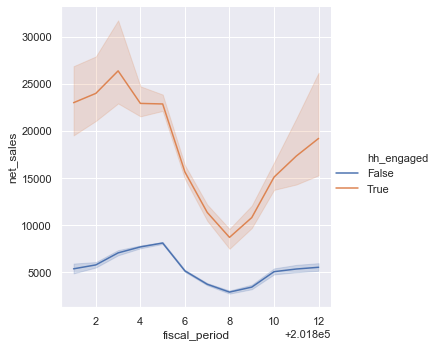

In [89]:
g = sns.relplot(x="fiscal_period", y="net_sales", kind="line", hue="hh_engaged", \
                data=sales_hh_fp_engaged_df.query('fiscal_year == 2018'))


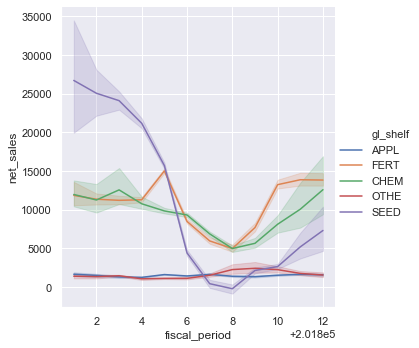

In [124]:
g = sns.relplot(x="fiscal_period", y="net_sales", kind="line", hue="gl_shelf", \
                data=sales_hh_fp_engaged_df.query('fiscal_year == 2018'))

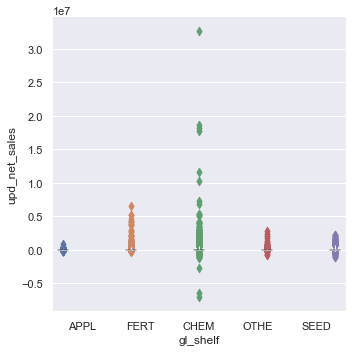

In [155]:
# 2018 sales in shelf
h = sns.catplot(x="gl_shelf", y="upd_net_sales", hue="gl_shelf", kind="boxen", \
                data=sales_hh_fp_sum_df.query('fiscal_year == 2018'));

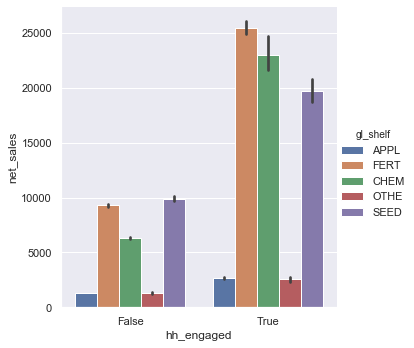

In [97]:
# comp between engaged and non-engaged avg sales for the year-to-date
# applies a function to obtain the estimate (taking the mean by default). 
# When there are multiple observations in each category, it also uses bootstrapping to compute a confidence 
# interval around the estimate and plots that using error bars:
sns.catplot(x="hh_engaged", y="net_sales", hue="gl_shelf", kind="bar", data=sales_hh_fp_engaged_df.query('fiscal_period >= 201808'));

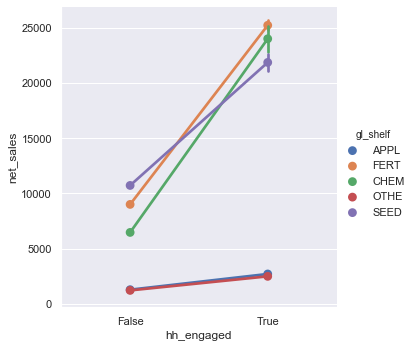

In [95]:
# point plot, for totals
sns.catplot(x="hh_engaged", y="net_sales", hue="gl_shelf", kind="point", data=sales_hh_fp_engaged_df);

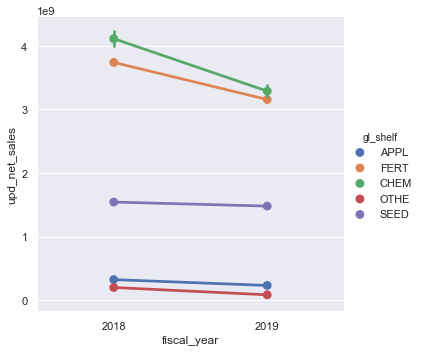

In [159]:
# estimator=<function mean>
sns.catplot(x="fiscal_year", y="upd_net_sales", hue="gl_shelf", kind="point", estimator=sum, data=sales_hh_fp_sum_df.query());

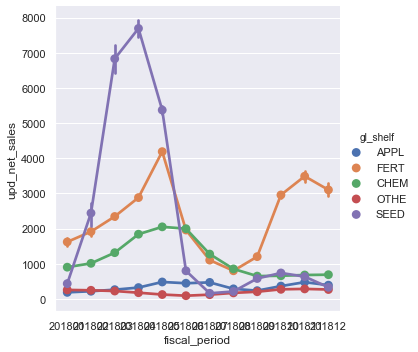

In [164]:
# estimator=<function mean>
sns.catplot(x="fiscal_period", y="upd_net_sales", hue="gl_shelf", kind="point", estimator=np.median, \
            data=sales_hh_fp_sum_df.query('fiscal_year == 2018'));

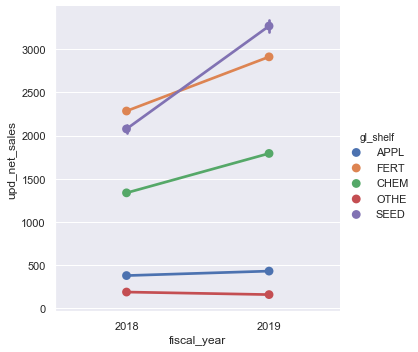

In [165]:
sns.catplot(x="fiscal_year", y="upd_net_sales", hue="gl_shelf", kind="point", estimator=np.median, \
            data=sales_hh_fp_sum_df);

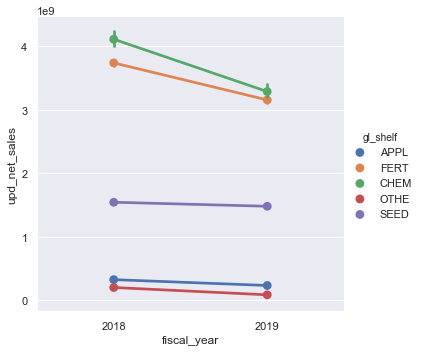

In [166]:
sns.catplot(x="fiscal_year", y="upd_net_sales", hue="gl_shelf", kind="point", estimator=sum, \
            data=sales_hh_fp_sum_df);

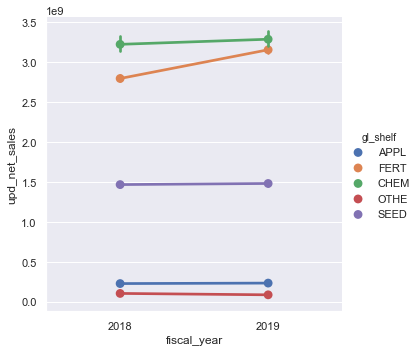

In [171]:
sns.catplot(x="fiscal_year", y="upd_net_sales", hue="gl_shelf", kind="point", estimator=sum, \
            data=sales_hh_fp_sum_df.query('(fiscal_period >= 201801 and fiscal_period <= 201807) \
            or (fiscal_period >= 201901 and fiscal_period <= 201907)'))

---
### QA for Account IDs in both Sets

In [ ]:
# what is the intersect of cust_key and accts in digital?
sales_acct_set = set(sales_acct_df['cust_id'].unique())
print(len(sales_acct_set))
sales_acct_set

In [ ]:
# hh acct id set
hh_accts_set = set(hh_acct_df['acct_id'].unique())
print(len(hh_accts_set))
hh_accts_set

In [ ]:
# are they all in the sales data, i hope???
# s.issubset(t) s <= t test whether every element in s is in t
print('hh_accts_set.issubset(sales_acct_set): {}'.format(hh_accts_set.issubset(sales_acct_set)))

In [ ]:
# which ones
print(len(hh_accts_set - sales_acct_set))
print(len(sales_acct_set - hh_accts_set))

In [ ]:
non_matching_acct_list = list(hh_accts_set - sales_acct_set)

In [ ]:
sales_acct_df.loc[sales_acct_df['cust_id'].isin(non_matching_acct_list), 'ret_ws']

In [ ]:
#pd.DataFrame(non_matching_acct_list).to_csv("/users/kmatson/documents/nutrien-digital/digital-vr-20190807/non_matching_acct_list.csv")

In [ ]:
# "Code that identifies the customer as a Dealer or Grower  type. Permitted values are: D, G. Values are:
# 'A' = 'Applicator'
# 'B' = 'Pine Belt'
# 'C' = 'Branch Cash Sales'
# 'D' = 'Dealer'
# 'E' = 'Test Account'
# 'F' = 'Seed Floor Stock'
# 'G' = 'Grower'
# 'H' = 'Parent Account'
# 'O' = 'Outside Distributor'
# 'P' = 'Pest Control'
# 'S' = 'Seed Dump'
# 'T' = 'Turf End User'
# 'V' = 'Veg Management'
# 'W' = 'Interunit'
# 'X' = 'Finance Partner (Corp AR)'
# 'Y' = 'Intercompany'
# 'Z' = 'Suspense Account'"

cust_type_lut = {'A': 'Applicator',
'B': 'Pine Belt',
'C': 'Branch Cash Sales',
'D': 'Dealer',
'E': 'Test Account',
'F': 'Seed Floor Stock',
'G': 'Grower',
'H': 'Parent Account',
'O': 'Outside Distributor',
'P': 'Pest Control',
'S': 'Seed Dump',
'T': 'Turf End User',
'V': 'Veg Management',
'W': 'Interunit',
'X': 'Finance Partner (Corp AR)',
'Y': 'Intercompany',
'Z': 'Suspense Account'}

cust_type_lut_df = pd.DataFrame.from_dict(cust_type_lut, orient='index')
cust_type_lut_df.columns = ['cust_type_str']
cust_type_lut_df['cust_type'] = cust_type_lut_df.index
cust_type_lut_df